In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from fastai import *

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

import seaborn as sns
# We are using whitegrid style for our seaborn plots. This is like the most basic one
sns.set_style(style = 'whitegrid')

In [5]:
PATH = "data/house_prices/"

In [6]:
df_raw = pd.read_csv(f'{PATH}train.csv', low_memory=False)

In [8]:
nrow, ncol = df_raw.shape
nrow, ncol

(1460, 81)

In [9]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

look at categorical variables

In [10]:
df_cat = df_raw.select_dtypes(include = 'object').copy()

In [15]:
df_cat.head().transpose()

,0,1,2,3,4
MSZoning,RL,RL,RL,RL,RL
Street,Pave,Pave,Pave,Pave,Pave
Alley,NaN,NaN,NaN,NaN,NaN
LotShape,Reg,Reg,IR1,IR1,IR1
LandContour,Lvl,Lvl,Lvl,Lvl,Lvl
Utilities,AllPub,AllPub,AllPub,AllPub,AllPub
LotConfig,Inside,FR2,Inside,Corner,FR2
LandSlope,Gtl,Gtl,Gtl,Gtl,Gtl
Neighborhood,CollgCr,Veenker,CollgCr,Crawfor,NoRidge
Condition1,Norm,Feedr,Norm,Norm,Norm


In [12]:
df_cat_stats = pd.DataFrame(columns = ['column', 'values', 'values_count_incna', 'values_count_nona', 
                                       'num_miss', 'pct_miss'])
tmp = pd.DataFrame()

for c in df_cat.columns:
    tmp['column'] = [c]
    tmp['values'] = [df_cat[c].unique()]
    tmp['values_count_incna'] = len(list(df_cat[c].unique()))
    tmp['values_count_nona'] = int(df_cat[c].nunique())
    tmp['num_miss'] = df_cat[c].isnull().sum()
    tmp['pct_miss'] = (df_cat[c].isnull().sum()/ len(df_cat)).round(3)*100
    df_cat_stats = df_cat_stats.append(tmp)
    
df_cat_stats

,column,values,values_count_incna,values_count_nona,num_miss,pct_miss
0,MSZoning,"[RL, RM, C (all), FV, RH]",5,5,0,0.0
0,Street,"[Pave, Grvl]",2,2,0,0.0
0,Alley,"[nan, Grvl, Pave]",3,2,1369,93.8
0,LotShape,"[Reg, IR1, IR2, IR3]",4,4,0,0.0
0,LandContour,"[Lvl, Bnk, Low, HLS]",4,4,0,0.0
0,Utilities,"[AllPub, NoSeWa]",2,2,0,0.0
0,LotConfig,"[Inside, FR2, Corner, CulDSac, FR3]",5,5,0,0.0
0,LandSlope,"[Gtl, Mod, Sev]",3,3,0,0.0
0,Neighborhood,"[CollgCr, Veenker, Crawfor, NoRidge, Mitchel, ...",25,25,0,0.0
0,Condition1,"[Norm, Feedr, PosN, Artery, RRAe, RRNn, RRAn, ...",9,9,0,0.0


In [13]:
df_cat_stats.sort_values(by = 'pct_miss', ascending = False).head(5)

,column,values,values_count_incna,values_count_nona,num_miss,pct_miss
0,PoolQC,"[nan, Ex, Fa, Gd]",4,3,1453,99.5
0,MiscFeature,"[nan, Shed, Gar2, Othr, TenC]",5,4,1406,96.3
0,Alley,"[nan, Grvl, Pave]",3,2,1369,93.8
0,Fence,"[nan, MnPrv, GdWo, GdPrv, MnWw]",5,4,1179,80.8
0,FireplaceQu,"[nan, TA, Gd, Fa, Ex, Po]",6,5,690,47.3


In [16]:
df_cat['SalePrice'] = df_raw.loc[df_cat.index, 'SalePrice'].copy()

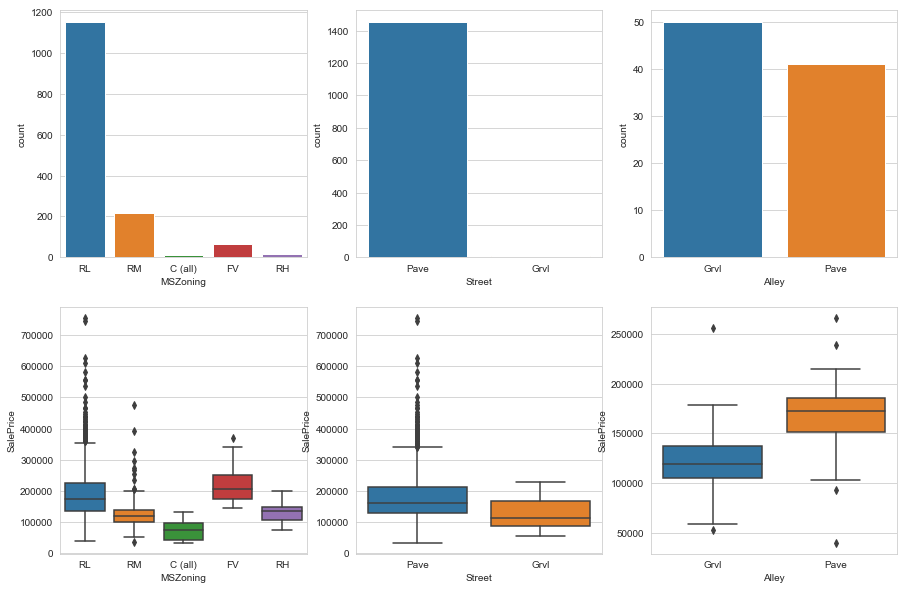

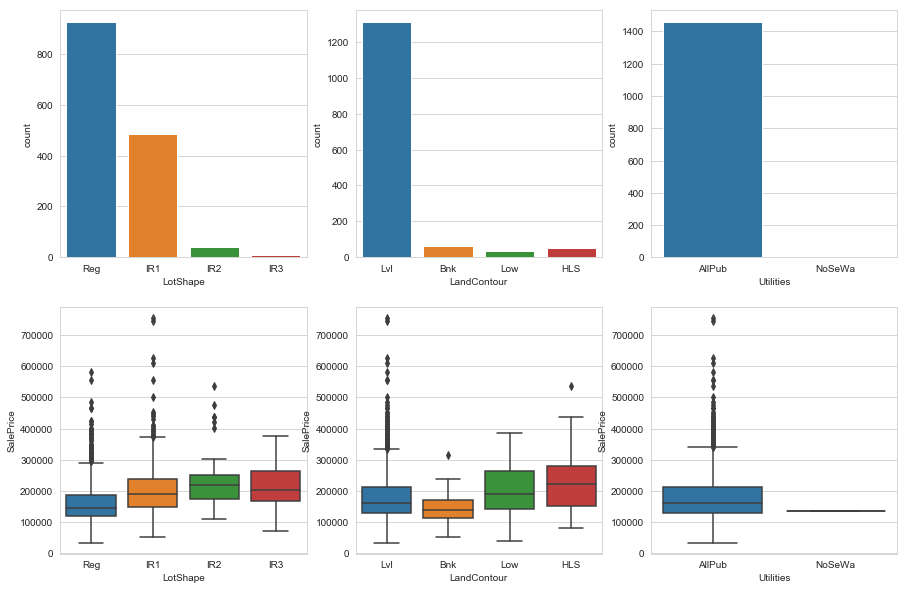

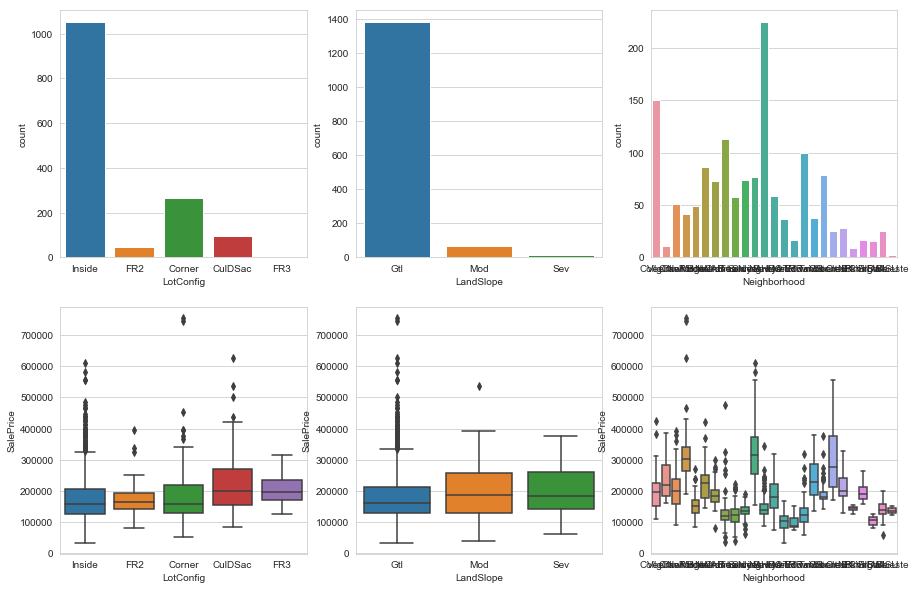

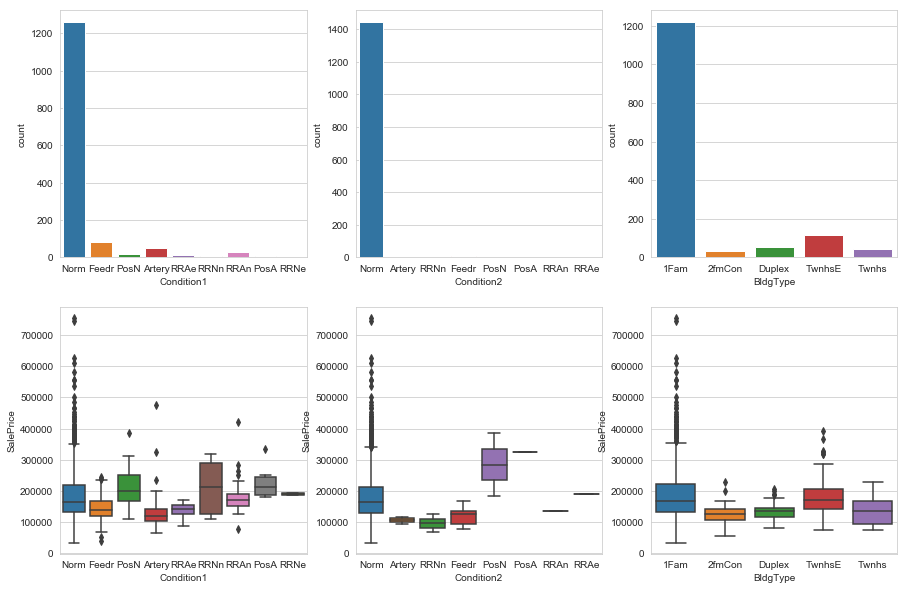

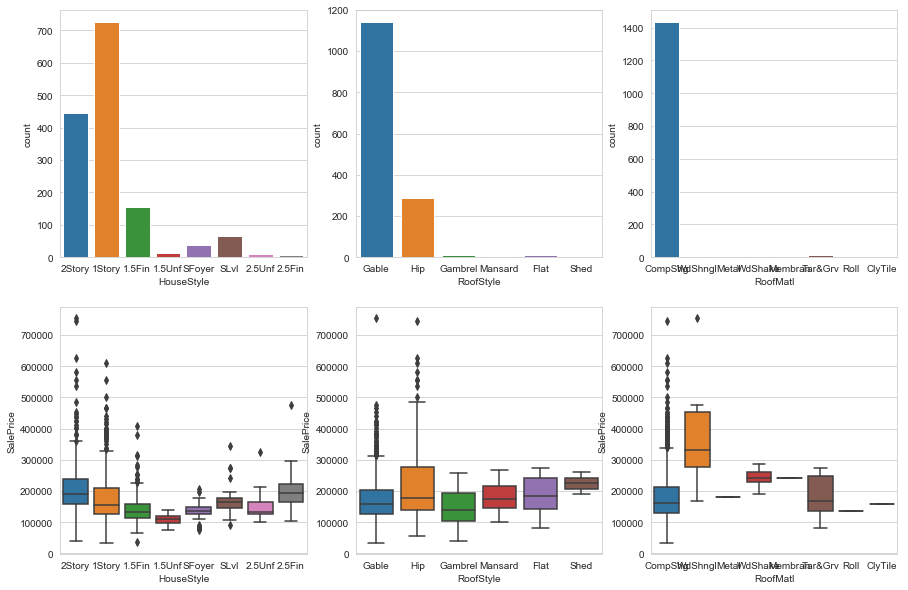

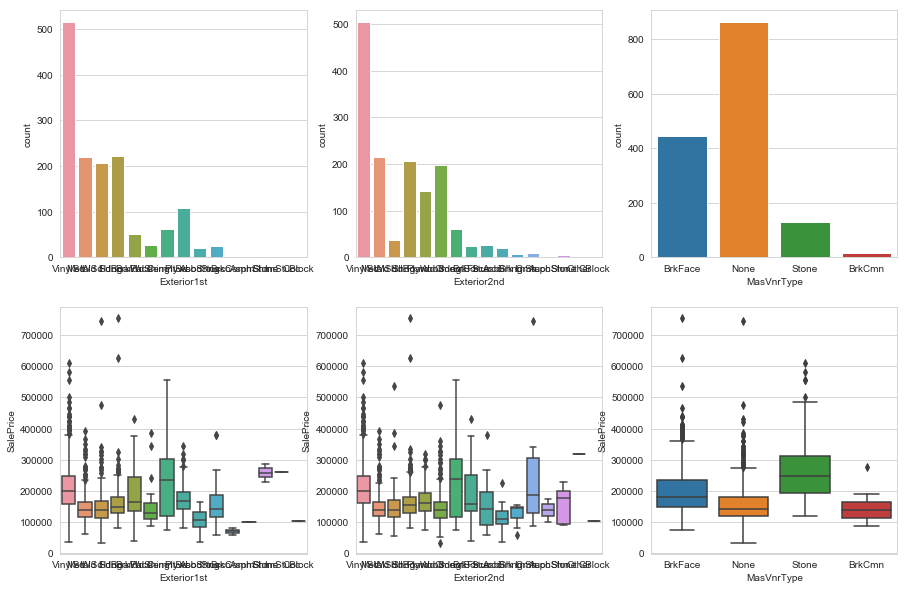

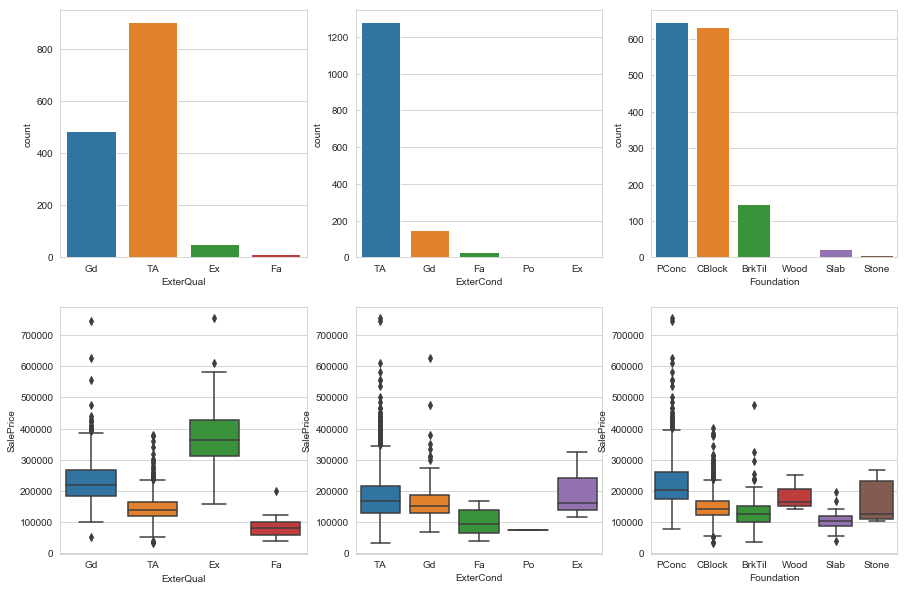

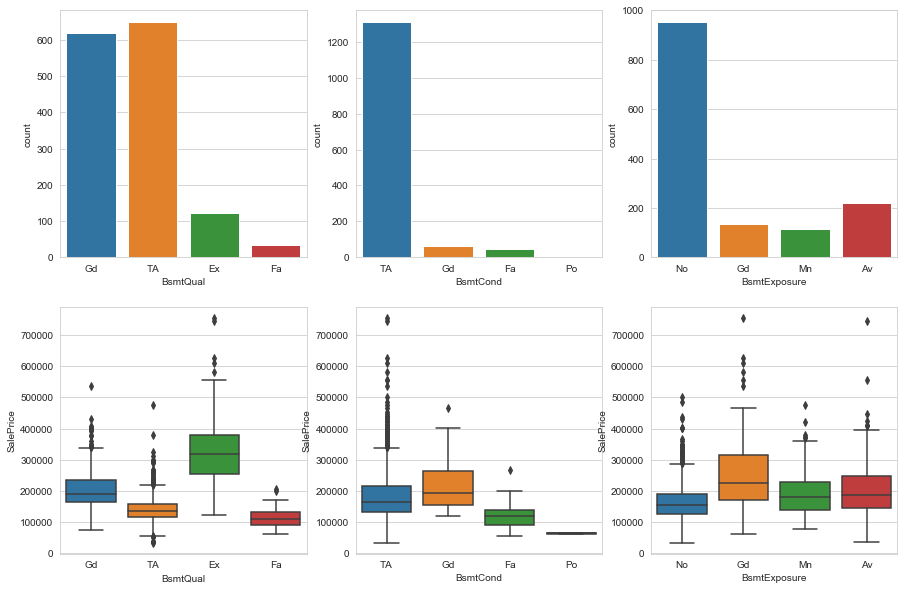

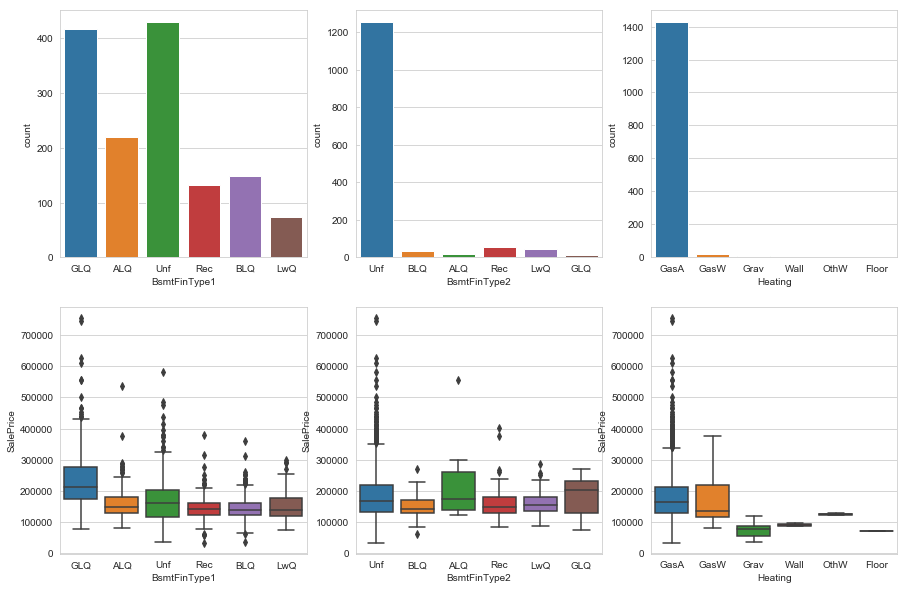

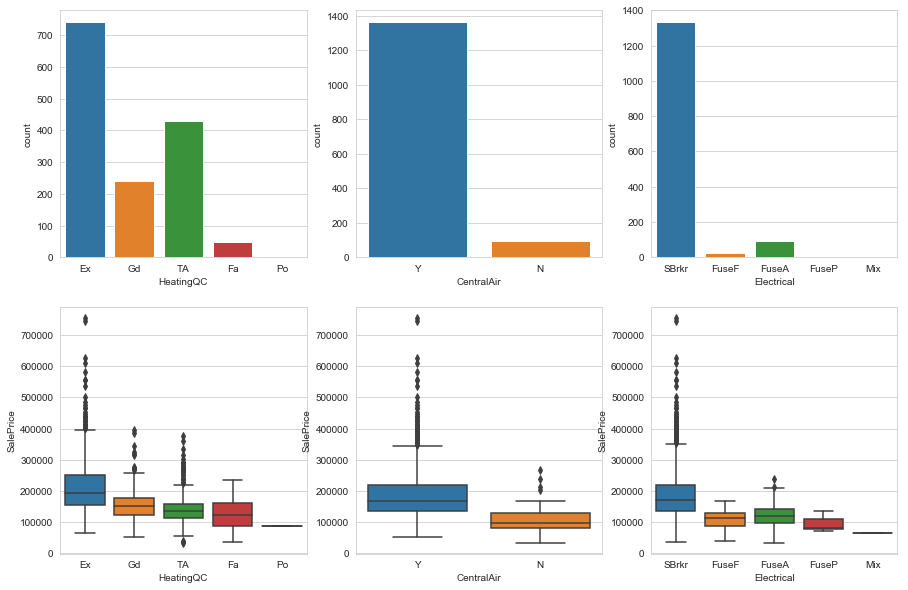

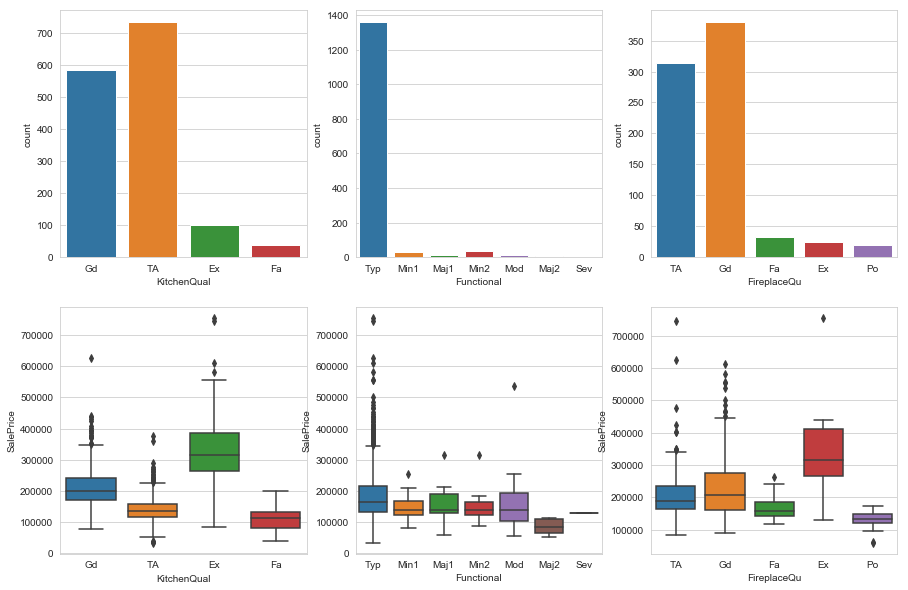

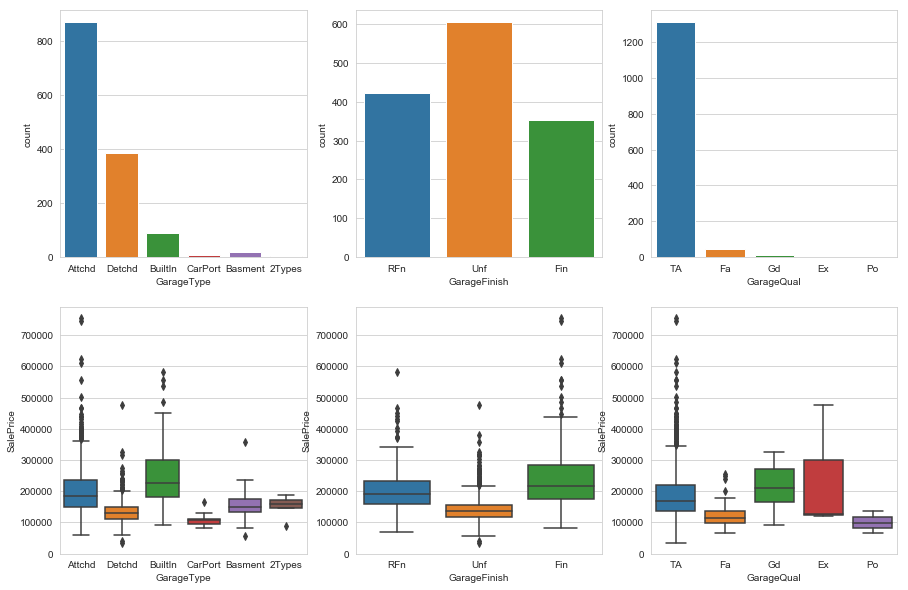

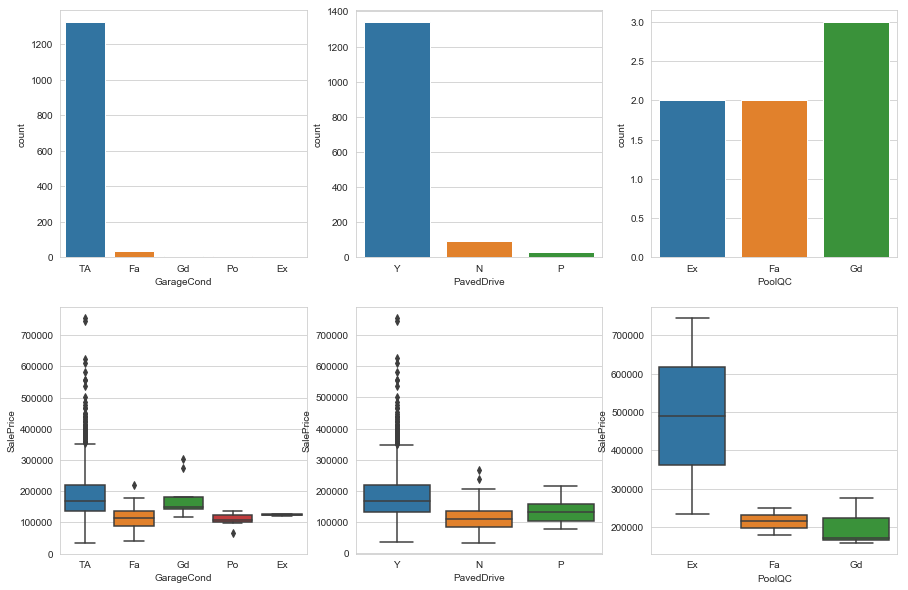

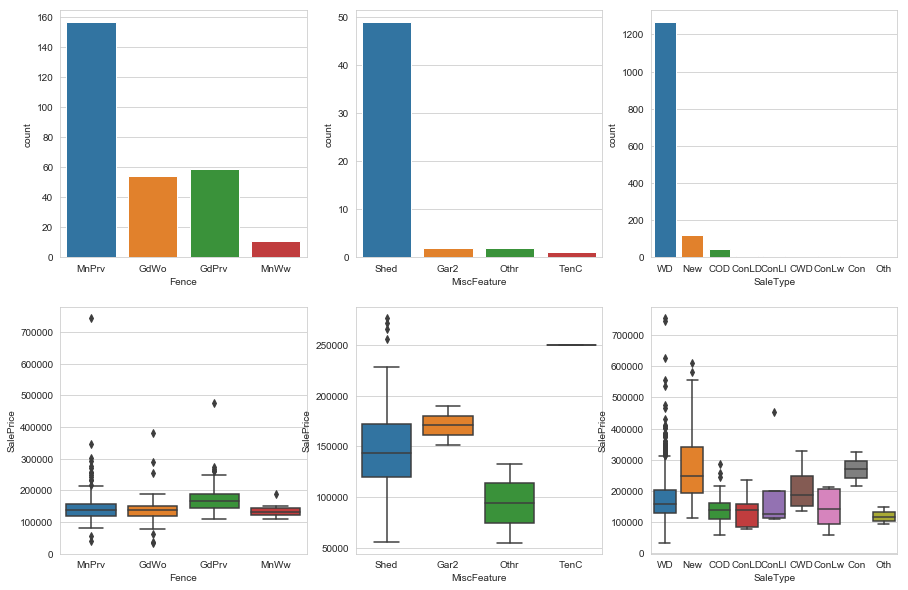

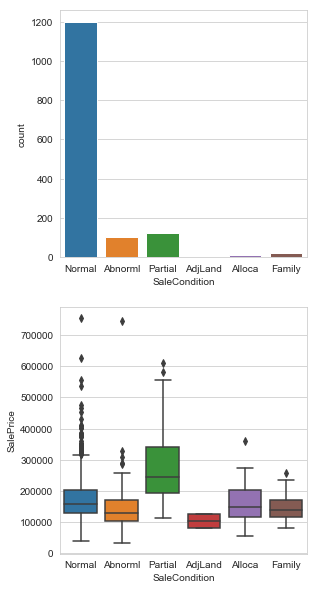

In [17]:
ix = 1
fig = plt.figure(figsize = (15,10))
for c in list(df_cat.columns):
    if ix <= 3:
        if c != 'SalePrice':
            ax1 = fig.add_subplot(2,3,ix)
            sns.countplot(data = df_cat, x=c, ax = ax1)
            ax2 = fig.add_subplot(2,3,ix+3)
            sns.boxplot(data=df_cat, x=c, y='SalePrice', ax=ax2)
            #sns.violinplot(data=df_cat, x=c, y='SalePrice', ax=ax2)
            #sns.swarmplot(data = df_cat, x=c, y ='SalePrice', color = 'k', alpha = 0.4, ax=ax2)
            
    ix = ix +1
    if ix == 4: 
        fig = plt.figure(figsize = (15,10))
        ix =1

In [42]:
df_raw['dateSold'] = pd.to_datetime(df_raw['YrSold'].astype(str)  + df_raw['MoSold'].astype(str), format='%Y%m')
df_raw.dateSold.head()

0   2008-02-01
1   2007-05-01
2   2008-09-01
3   2006-02-01
4   2008-12-01
Name: dateSold, dtype: datetime64[ns]

In [44]:
df_raw.dateSold.min(), df_raw.dateSold.max()

(Timestamp('2006-01-01 00:00:00'), Timestamp('2010-07-01 00:00:00'))

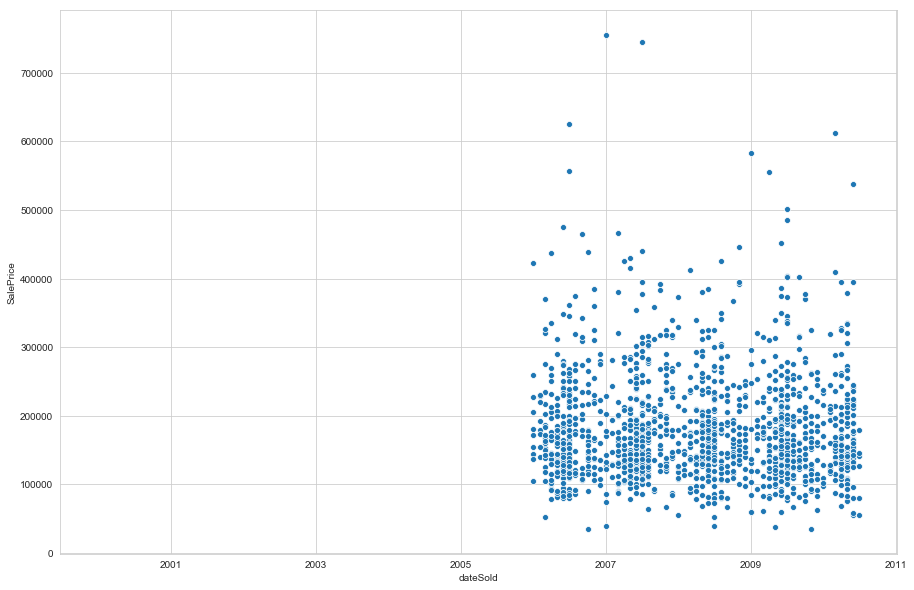

In [48]:
fig = plt.figure(figsize = (15,10))
ax=sns.scatterplot(x='dateSold', y='SalePrice', data=df_raw)

In [27]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

1stFlrSF         0.000000
2ndFlrSF         0.000000
3SsnPorch        0.000000
Alley            0.937671
BedroomAbvGr     0.000000
BldgType         0.000000
BsmtCond         0.025342
BsmtExposure     0.026027
BsmtFinSF1       0.000000
BsmtFinSF2       0.000000
BsmtFinType1     0.025342
BsmtFinType2     0.026027
BsmtFullBath     0.000000
BsmtHalfBath     0.000000
BsmtQual         0.025342
BsmtUnfSF        0.000000
CentralAir       0.000000
Condition1       0.000000
Condition2       0.000000
Electrical       0.000685
EnclosedPorch    0.000000
ExterCond        0.000000
ExterQual        0.000000
Exterior1st      0.000000
Exterior2nd      0.000000
Fence            0.807534
FireplaceQu      0.472603
Fireplaces       0.000000
Foundation       0.000000
FullBath         0.000000
Functional       0.000000
GarageArea       0.000000
GarageCars       0.000000
GarageCond       0.055479
GarageFinish     0.055479
GarageQual       0.055479
GarageType       0.055479
GarageYrBlt      0.055479
GrLivArea   

replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [55]:
def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = col.cat.codes+1

def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

In [56]:
df, y, nas = proc_df(df_raw, 'SalePrice')

fit model

In [45]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

0.9750029261566399

Predict on test set

In [66]:
df_raw_test = pd.read_csv(f'{PATH}test.csv', low_memory=False)
apply_cats(df_raw_test, df_raw)
df_test, _, nas = proc_df(df_raw_test, na_dict=nas)

In [69]:
df.shape, df_test.shape, df_raw.shape, df_raw_test.shape

((1460, 83), (1459, 83), (1460, 81), (1459, 80))

In [71]:
pred_test = m.predict(df_test)

remeber to exp salesprice

In [72]:
pred_test = np.exp(pred_test)

In [78]:
df_test['SalePrice']=pred_test

summary of predictions

In [83]:
df_test.SalePrice.describe() 

(count      1459.000000
 mean     175403.350824
 std       72236.881631
 min       51441.181532
 25%      127470.231645
 50%      154906.968489
 75%      207976.187505
 max      545384.353688
 Name: SalePrice, dtype: float64, 180921.19589041095)

summary of training labels

In [89]:
np.exp(y).mean(), np.exp(y).min(), np.exp(y).max()

(180921.19589041095, 34900.00000000001, 754999.9999999999)

In [90]:
csv_fn=f'{PATH}submission1.csv'
df_test[['Id','SalePrice']].to_csv(csv_fn, index=False)

In [ ]:
!kaggle competitions submit house-prices-advanced-regression-techniques -f submission1.csv -m "first random forest"

look at if categories should be ordered

In [92]:
df_raw2 = pd.read_csv(f'{PATH}train.csv', low_memory=False)

In [100]:
cat_vars = []
for col in df_raw2:
    if not is_numeric_dtype(df_raw2[col]):
        cat_vars.append(col)
cat_vars

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [ ]:
for df_raw..cat.categories